<a href="https://colab.research.google.com/github/afperez232/IBM-Data-Science/blob/main/Prueba_Calcs_com.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# FLEXURAL CAPACITY HSS COLUMN SPLICE CONNECTION (AISC-22)


This notebook shows step by step how to calculate the **flexural capacity** of an HSS column splice connection, following **AISC 360-22** using **ASD** (Allowable Strength Design).


In [110]:
import math

### 1. Entrey Data

In this step we define the **material properties** and the **section properties** of the HSS column.


In [111]:
material_properties = {
    "fy": 50,  # Yield Strength [ksi]
    "E": 29000, # Young's Modulus [ksi]
    "Sy": 59.5 # Plastic Section Modulus [ksi]
}

section_properties = {
    "b": 10.3, # workable flat [inches]
    "t": 0.349, # Thickness [inches]
    "Zx": 69.2, # Plastic Section Modulus [in^3]
    "Mu": 20 #Acting Moment
}



### 2. classification Element (AISC)

We will calculate the slenderness ratio (`lambda`) and compare it to the AISC standard limits to determine if the element is compact. For an HSS section in bending, the slenderness ratio of the wall element (`b/t`) should be compared to the compression limits of AISC 360 Section B4.

*   Compact Limit (`λp`): 1.12 * sqrt(E/Fy)
*   Non Copmact Limiti (`λr`): 1.40 * sqrt(E/Fy)



In [112]:
fy = material_properties["fy"]
E = material_properties["E"]
Sy=material_properties["Sy"]
b = section_properties["b"]
t = section_properties["t"]

# Calculate Widht-to-Thickness ratio
lamb = b / t

# AISC B4.1b (Table B4.1b, Case 17 for HSS)
lambda_p = 1.12 * math.sqrt(E / fy) # Compact limit
lambda_r = 1.40 * math.sqrt(E / fy) # Non-compact limit

print(f"Relation b/t (lambda): {lamb:.2f}")
print(f"Compact Limit (lambda_p): {lambda_p:.2f}")
print(f"Non-Compact (lambda_r): {lambda_r:.2f}")

if lamb <= lambda_p:
    element_classification = "Compact"
elif lamb <= lambda_r:
    element_classification = "Non Compact"
else:
    element_classification = "Slender"

print(f"Clasificación del elemento: {element_classification}")

Relation b/t (lambda): 29.51
Compact Limit (lambda_p): 26.97
Non-Compact (lambda_r): 33.72
Clasificación del elemento: Non Compact


### 3. Moments Mp y My


Once we know the section classification, we calculate two key bending strengths:

- **Plastic moment, Mp = Fy · Zx**  
  This is the theoretical maximum bending strength if the section could fully yield in compression and tension (ideal plastic behavior).

- **Elastic yield moment, My = Fy · Sx**  
  This is the bending moment at which the extreme fiber of the section first reaches the yield stress.


In [113]:
fy = material_properties["fy"]
Zx = section_properties["Zx"]
omega = 1.67 # Factor de seguridad/resistencia para ASD

# Plastic Moment
M_p = Zx * fy
print(f"Plastic Moment: {M_p/12:.2f} kip-ft")

# Elastic Yield Moment
M_y = (Sy * fy) # Convert to kip-ft and apply safety factor
print(f"Elastic Yield Moment: {M_y/12:.2f} kip-ft")

Plastic Moment: 288.33 kip-ft
Elastic Yield Moment: 247.92 kip-ft


###4. Reduction due to local buckling of non-compact flange (Equation F7-2)

Because our HSS wall is **noncompact**, AISC 360-22 (Section F7, Equation F7-2) tells us that the nominal moment `Mn` must be **reduced** between `Mp` and `My`.

In [114]:
#Nominal Moment
M_n=M_p-(M_p-fy*Sy)*(lamb-lambda_p)/(lambda_r-lambda_p)
print(f"Nominal Moment: {M_n/12:.2f} kip-ft")

Nominal Moment: 273.11 kip-ft


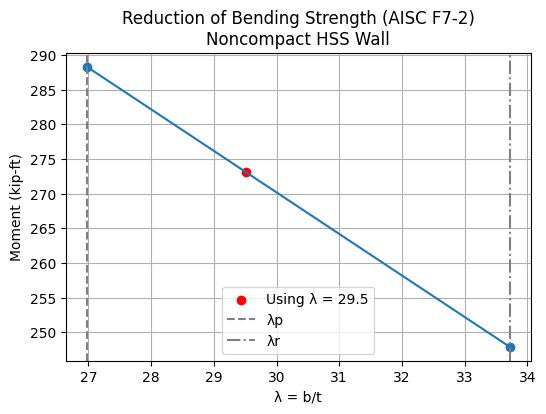

In [115]:
import matplotlib.pyplot as plt
import numpy as np

# Valores calculados
lambda_p
lambda_r
lamb

Mp = M_p/12   # kip-ft
My = M_y/12   # kip-ft
Mn = M_n/12   # kip-ft

# Gráfica
plt.figure(figsize=(6,4))

# Línea de interpolación
plt.plot([lambda_p, lambda_r], [Mp, My], '-o')

# Punto de tu sección
plt.scatter(lamb, Mn, color='red', label='Using λ = 29.5')

plt.axvline(lambda_p, color='gray', linestyle='--', label='λp')
plt.axvline(lambda_r, color='gray', linestyle='-.', label='λr')

plt.title("Reduction of Bending Strength (AISC F7-2)\nNoncompact HSS Wall")
plt.xlabel("λ = b/t")
plt.ylabel("Moment (kip-ft)")
plt.legend()
plt.grid(True)
plt.show()


###5. Allowable Strenght (ASD)


Up to this point, `Mn` is the **nominal moment capacity** of the section according to AISC (strength without safety factors).


In [116]:
omega=1.67 #
M_a=M_n/omega
print(f"Alloweb Moment: {M_a/12:.2f} kip-ft")

Alloweb Moment: 163.54 kip-ft


###6. Strength Verification

In [117]:
acting_moment = section_properties["Mu"]
allowable_moment = M_a / 12 # Convert M_a from kip-in to kip-ft

print(f"Momento Actuante (M_u): {acting_moment:.2f} kip-ft")
print(f"Momento Admisible (M_a): {allowable_moment:.2f} kip-ft")

moment_ratio = acting_moment / allowable_moment

print(f"Ratio M_u / M_a: {moment_ratio:.2f}")

if moment_ratio > 1:
    print("The section DOES NOT COMPLY with the bending stresses. The section must be modified.")
else:
    print("The section COMPLIES with the bending stresses.")

Momento Actuante (M_u): 20.00 kip-ft
Momento Admisible (M_a): 163.54 kip-ft
Ratio M_u / M_a: 0.12
The section COMPLIES with the bending stresses.
